# **Sales Prediction**

In [ ]:
import numpy as np
import pandas as pd

df = pd.read_csv('/content/advertising.csv')
print(df.shape)
df.head(4)

(200, 4)


,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


<Axes: >

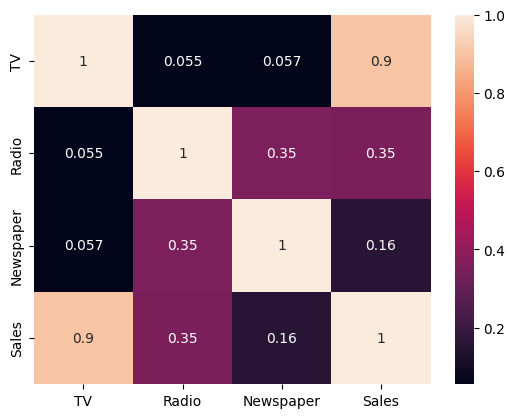

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=corr_matrix.values)

## Data Cleaning & Preprocessing

In [ ]:
# Check for Null Values
df.isnull().sum()

TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64

## Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop('Sales', axis=1)
Y = df['Sales']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

X_train = pd.DataFrame(X_train).reset_index(drop=True)
X_test = pd.DataFrame(X_test).reset_index(drop=True)
Y_train = pd.DataFrame(Y_train).reset_index(drop=True)
Y_test = pd.DataFrame(Y_test).reset_index(drop=True)

X_train.head(2)

,TV,Radio,Newspaper
0,31.5,24.6,2.2
1,97.2,1.5,30.0


In [ ]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((160, 3), (40, 3), (160, 1), (40, 1))

## Outlier Detection & Removal

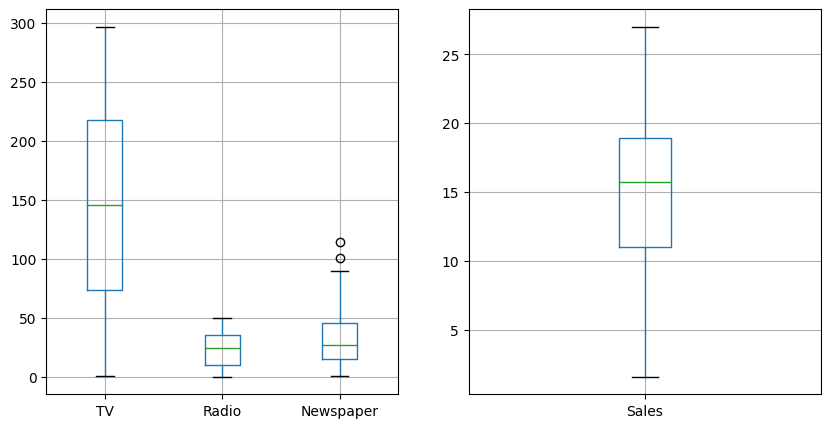

In [ ]:
## Check for outliers in Train Data
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
X_train.boxplot()
plt.subplot(1,2,2)
Y_train.boxplot();

Observation: Newspaper feature has outleirs

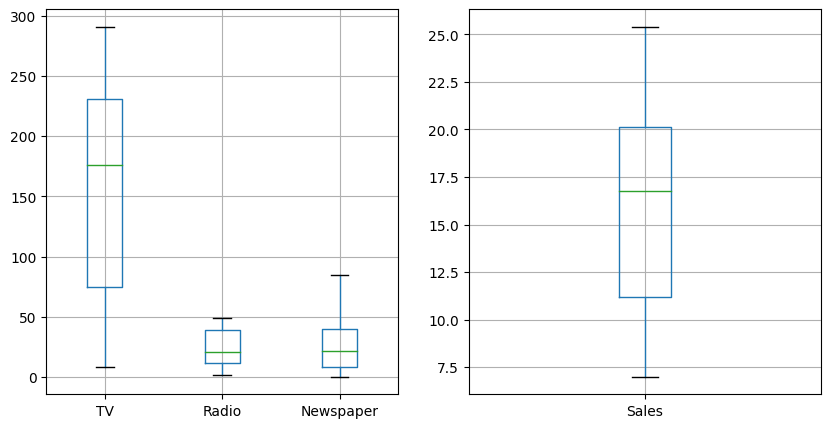

In [ ]:
## Check for outliers in test data
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
X_test.boxplot()
plt.subplot(1,2,2)
Y_test.boxplot();

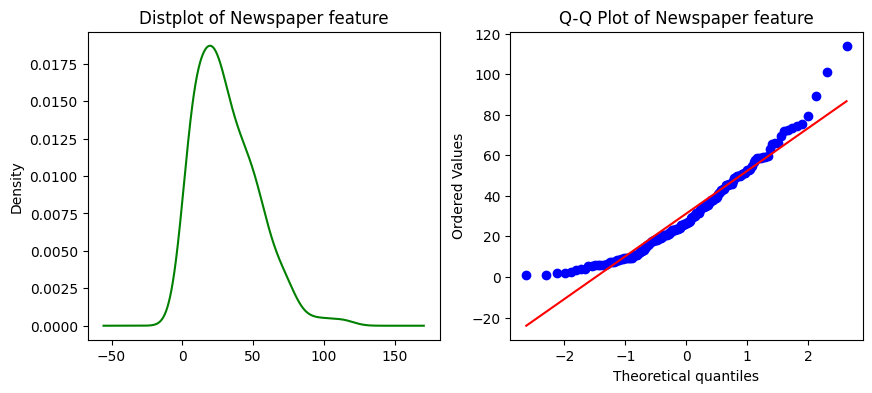

In [ ]:
## Checking distribution of X_train's Newspaper feature and X_test's Newspaper feature
import  scipy.stats as stats
import pylab

def feature_distribution(df, feature):
  plt.figure(figsize=(10,4))
  plt.subplot(1,2,1)
  plt.title(f"Distplot of {feature} feature")
  df[feature].plot(kind='kde', color='green')
  plt.subplot(1,2,2)
  stats.probplot(df[feature], dist='norm', plot=pylab)
  plt.title(f"Q-Q Plot of {feature} feature");

feature_distribution(X_train, 'Newspaper')

Observation: The distribtuion of Newspaper feature is bit skewed and is not perfectly gaussian

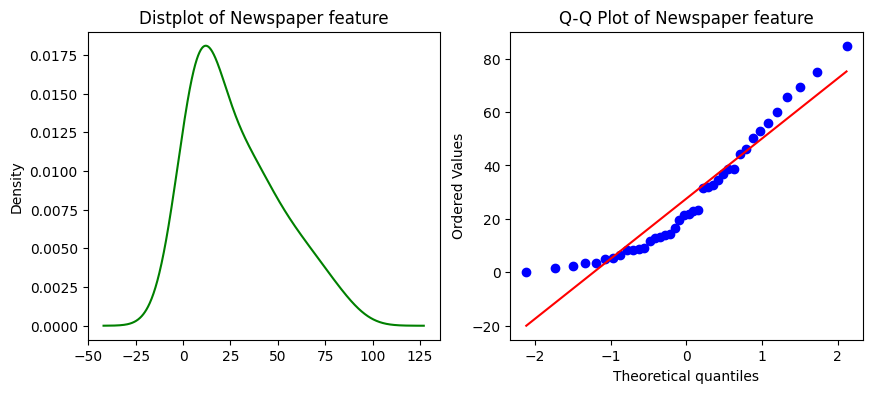

In [ ]:
feature_distribution(X_test, 'Newspaper')

<Axes: >

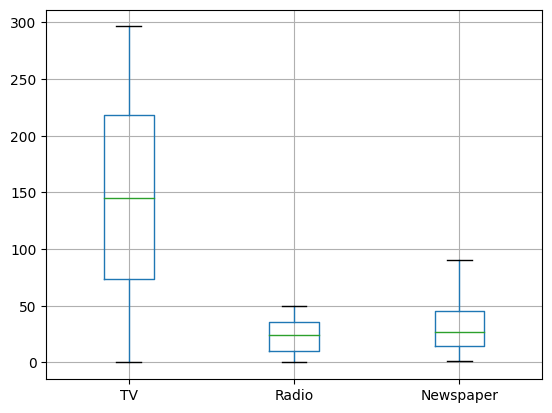

In [ ]:
# Outleir Removal(Imputation) using IQR Method
def outlier_impute_with_upper_range(df, feature):
  IQR = df[feature].quantile(0.75) - df[feature].quantile(0.25)
  upper_boundary = df[feature].quantile(0.75) + (IQR*1.5)
  lower_boundary = df[feature].quantile(0.25) - (IQR*1.5)
  df.loc[df[feature]>=upper_boundary, feature] = upper_boundary

outlier_impute_with_upper_range(X_train, 'Newspaper')

X_train.boxplot()

## Feature Transformation

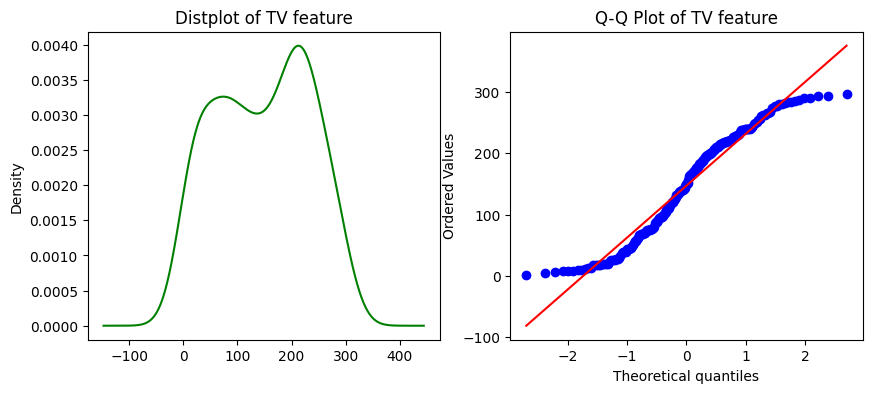

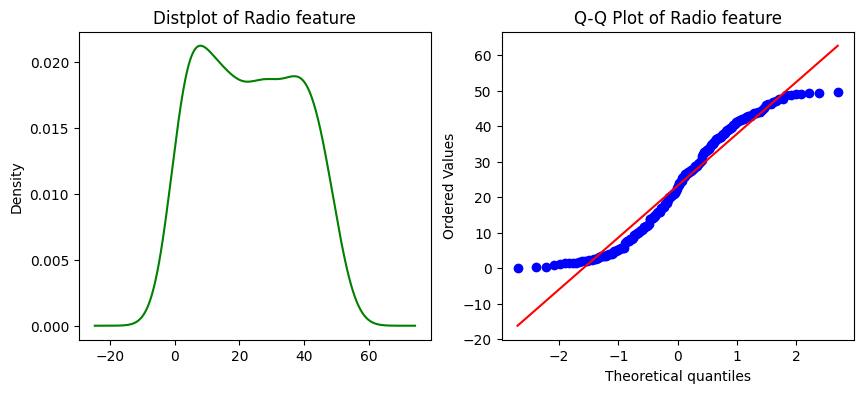

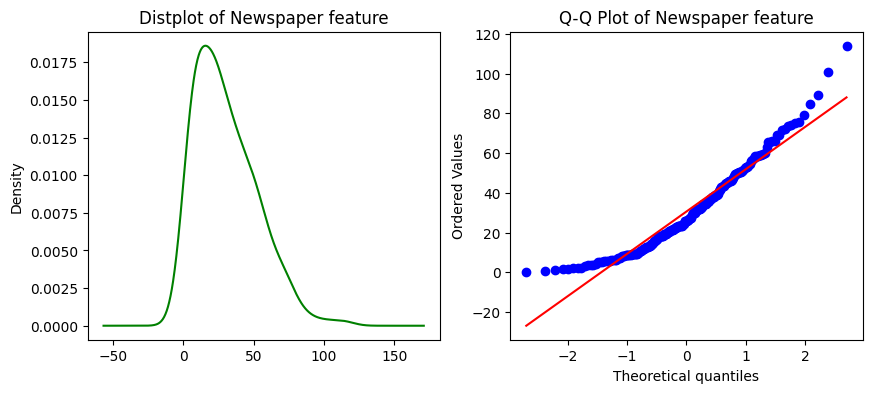

In [ ]:
## Check distributions of X_train columns
for i in X_train.columns:
  feature_distribution(df, i)

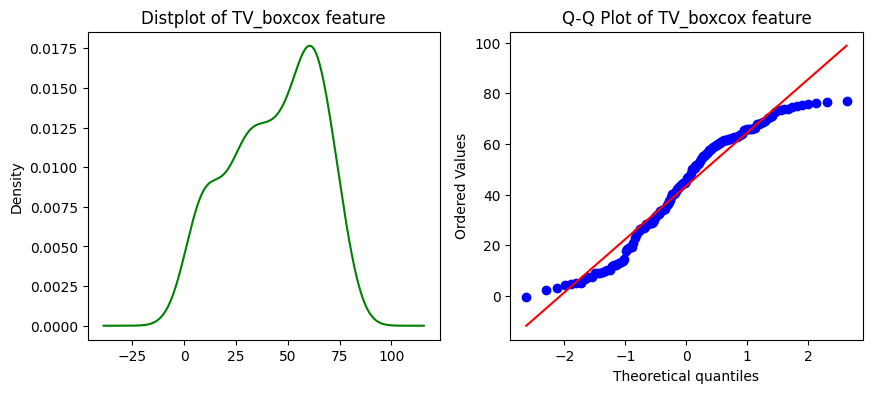

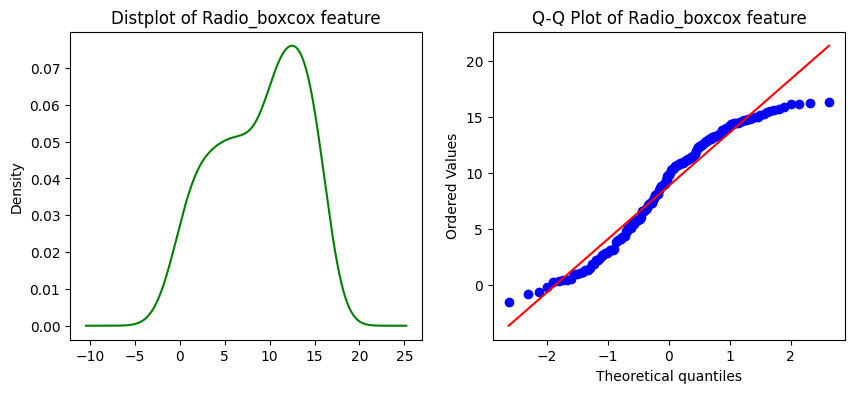

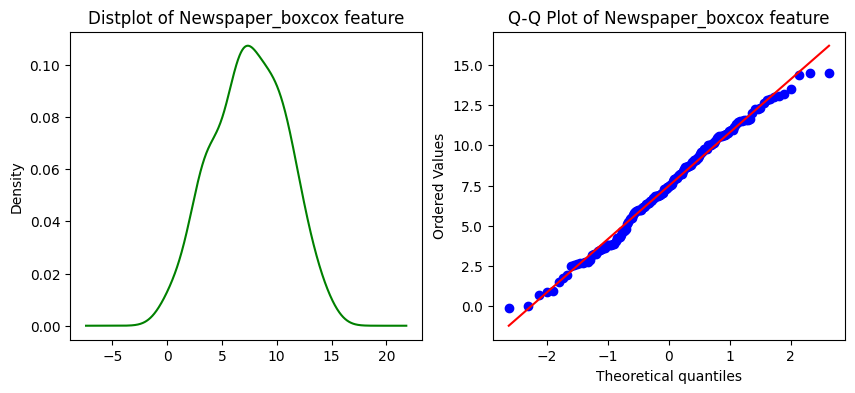

In [ ]:
# Boxcox Transformation

def boxcox_transform(df, feature):
  transformed_data, parameter = stats.boxcox(df[feature]+0.01) ## Adding 0.01 to make sure zero values are also considered
  df[feature + "_boxcox"] = transformed_data
  df.drop(columns=feature, axis=1, inplace=True)
  feature_distribution(df, feature + "_boxcox")


for i in X_train.columns:
  boxcox_transform(X_train, i)

In [ ]:
X_train.head(2)

,TV_boxcox,Radio_boxcox,Newspaper_boxcox
0,14.727816,10.025334,0.951406
1,34.303142,0.469004,7.982968


In [ ]:
X_test.head(2)

,TV,Radio,Newspaper
0,117.2,14.7,5.4
1,265.6,20.0,0.3


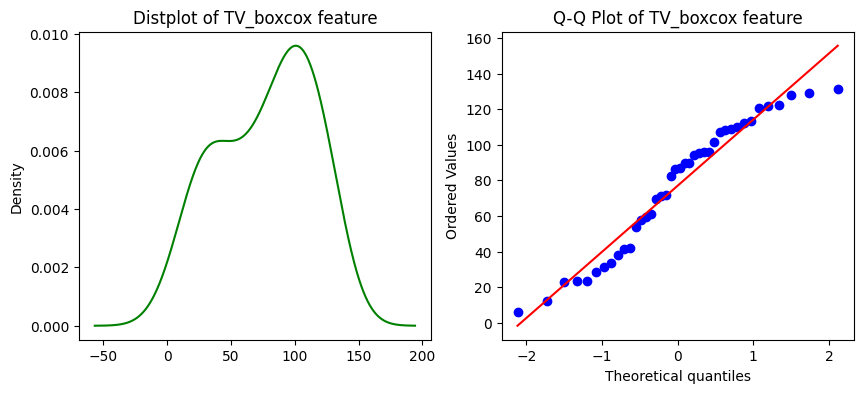

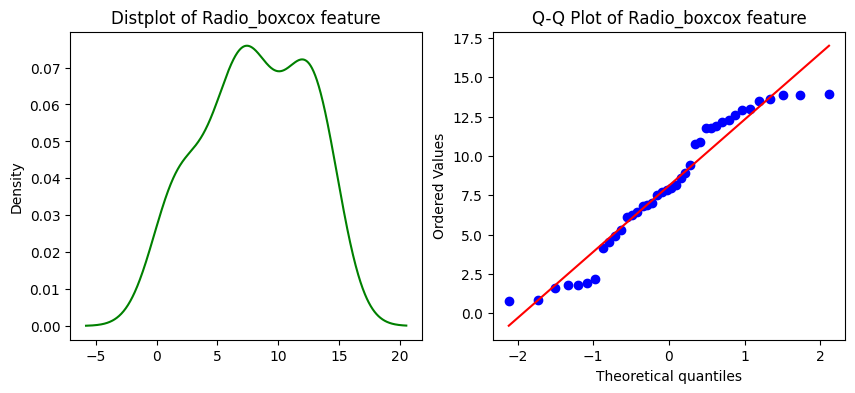

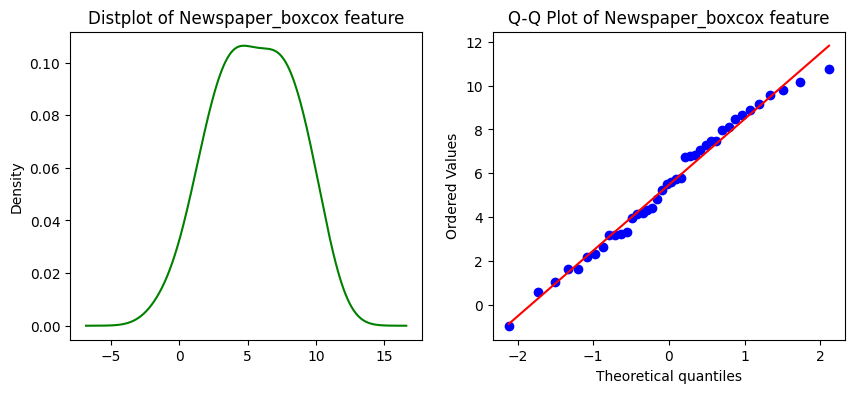

In [ ]:
# Boxcox transformation of X_test
for i in X_test.columns:
  boxcox_transform(X_test, i)

In [ ]:
X_test.head(2)

,TV_boxcox,Radio_boxcox,Newspaper_boxcox
0,61.297822,6.227072,2.307633
1,121.898742,7.726072,-0.959378


## Feature Scaling

Text(0.5, 1.0, 'Boxplot of X_test')

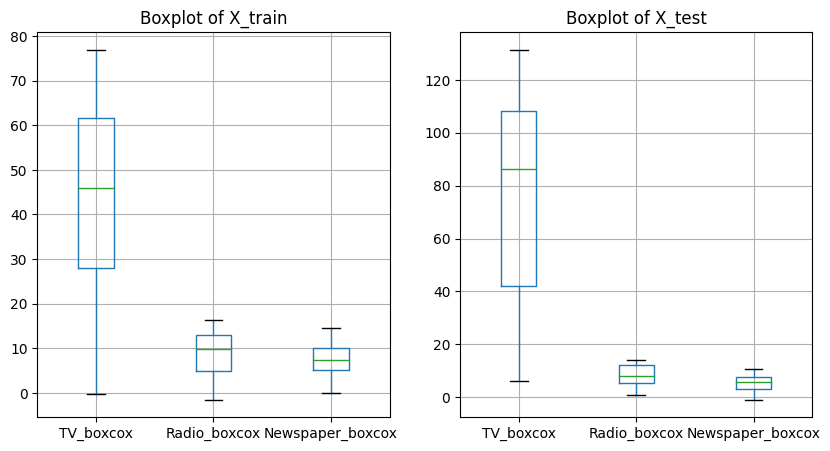

In [ ]:
# Boxplot before feature scaling
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
X_train.boxplot()
plt.title(f"Boxplot of X_train")
plt.subplot(1,2,2)
X_test.boxplot()
plt.title(f"Boxplot of X_test")

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train, columns=X_train.columns).reset_index(drop=True)
X_test_scaled = pd.DataFrame(X_test, columns=X_test.columns).reset_index(drop=True)

Text(0.5, 1.0, 'Boxplot of X_test')

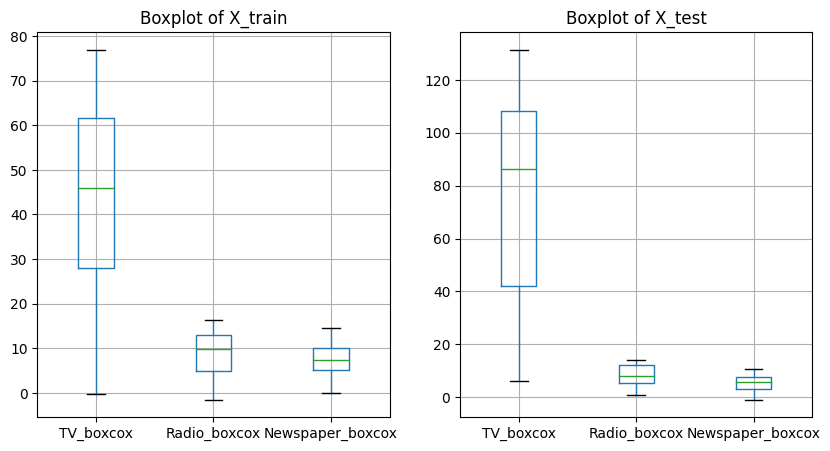

In [ ]:
## Boxplot after Feature scaling
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
X_train.boxplot()
plt.title(f"Boxplot of X_train")
plt.subplot(1,2,2)
X_test.boxplot()
plt.title(f"Boxplot of X_test")

## Model Training and Evaluation

In [ ]:
## Create a function to evaluate  model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def evaluate_model(true, predicted):
  mae = mean_absolute_error(true, predicted)
  mse = mean_squared_error(true, predicted)
  rmse = np.sqrt(mse)
  r2_square = r2_score(true, predicted)
  return mae, mse, rmse, r2_square

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost
from xgboost import XGBRegressor

models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XG Boost Regressor": XGBRegressor()
}

for i in range(len(list(models))):
  model = list(models.values())[i]
  model.fit(X_train_scaled, Y_train)
  ## Make predictions
  Y_train_pred = model.predict(X_train_scaled)
  Y_test_pred = model.predict(X_test_scaled)
  ## Evaluate
  model_train_mae, model_train_mse, model_train_rmse, model_train_r2 = evaluate_model(Y_train, Y_train_pred)
  model_test_mae, model_test_mse, model_test_rmse, model_test_r2 = evaluate_model(Y_test, Y_test_pred)

  print(list(models.keys())[i])
  print("Model Performance for Training Set")
  print("Mean Squared Error: {:.4f}".format(model_train_mse))
  print("Mean Absolute Error: {:.4f}".format(model_train_mae))
  print("Root Mean Squared Error: {:.4f}".format(model_train_rmse))
  print("R2 Score: {:.4f}".format(model_train_r2))

  print("-------------------------------------------------------------")

  print("Model Performance for Test Set")
  print("Mean Sqaured Error: {:.4f}".format(model_test_mse))
  print("Mean Absolute Error: {:.4f}".format(model_test_mae))
  print("Root Mean Sqaured Error: {:.4f}".format(model_test_rmse))
  print("R2 Score: {:.4f}".format(model_test_r2))
  print("-------------------------------------------------------------")
  print("\n")

Linear Regression
Model Performance for Training Set
Mean Squared Error: 2.3400
Mean Absolute Error: 1.1843
Root Mean Squared Error: 1.5297
R2 Score: 0.9154
-------------------------------------------------------------
Model Performance for Test Set
Mean Sqaured Error: 56.0263
Mean Absolute Error: 6.4007
Root Mean Sqaured Error: 7.4851
R2 Score: -1.0198
-------------------------------------------------------------


Lasso
Model Performance for Training Set
Mean Squared Error: 2.3843
Mean Absolute Error: 1.1924
Root Mean Squared Error: 1.5441
R2 Score: 0.9138
-------------------------------------------------------------
Model Performance for Test Set
Mean Sqaured Error: 55.9281
Mean Absolute Error: 6.3872
Root Mean Sqaured Error: 7.4785
R2 Score: -1.0163
-------------------------------------------------------------


Ridge
Model Performance for Training Set
Mean Squared Error: 2.3400
Mean Absolute Error: 1.1843
Root Mean Squared Error: 1.5297
R2 Score: 0.9154
---------------------------

<ipython-input-224-7997746561a3>:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled, Y_train)


Random Forest Regressor
Model Performance for Training Set
Mean Squared Error: 0.2007
Mean Absolute Error: 0.3450
Root Mean Squared Error: 0.4480
R2 Score: 0.9927
-------------------------------------------------------------
Model Performance for Test Set
Mean Sqaured Error: 10.3014
Mean Absolute Error: 2.4060
Root Mean Sqaured Error: 3.2096
R2 Score: 0.6286
-------------------------------------------------------------


XG Boost Regressor
Model Performance for Training Set
Mean Squared Error: 0.0000
Mean Absolute Error: 0.0014
Root Mean Squared Error: 0.0019
R2 Score: 1.0000
-------------------------------------------------------------
Model Performance for Test Set
Mean Sqaured Error: 10.7303
Mean Absolute Error: 2.4432
Root Mean Sqaured Error: 3.2757
R2 Score: 0.6132
-------------------------------------------------------------




## HyperParameter Tuning

In [ ]:
# Hyperparameter Tuning using RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

rf_params = {"max_depth": [5,8,15,None,10],
             "max_features": [5,7, "auto", 8],
             "min_samples_split": [2,8,15,20],
             "n_estimators": [100,200,500,1000]}
xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5,8,12,20,30],
                  "n_estimators": [100,200,300,500],
                  "colsample_bytree": [0.5, 0.8, 1, 0.3, 0.4]
}

# Hyperparameter Tuning
randomcv_models = [
    ('XGBoost', XGBRegressor(), xgboost_params),
    ('RF', RandomForestRegressor(), rf_params)
]

model_param = {} ##initiaizing
for name, model, params in randomcv_models:
  grid = GridSearchCV(estimator=model, param_grid=params,
                      cv=3, verbose=2, n_jobs=-1)
  grid.fit(X_train_scaled, Y_train)
  model_param[name] = grid.best_params_

  for model_name in model_param:
    print(f"--------------- Best Parameters for {model_name} ---------------")
    print(model_param[model_name])
    print('------------------------------------------------------')

Fitting 3 folds for each of 200 candidates, totalling 600 fits
--------------- Best Parameters for XGBoost ---------------
{'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
------------------------------------------------------
Fitting 3 folds for each of 320 candidates, totalling 960 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


--------------- Best Parameters for XGBoost ---------------
{'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
------------------------------------------------------
--------------- Best Parameters for RF ---------------
{'max_depth': 10, 'max_features': 5, 'min_samples_split': 2, 'n_estimators': 200}
------------------------------------------------------


In [ ]:
# Retraining models with best parameters

models = {
    "XGB Regressor": XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, colsample_bytree=1 ),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=200,
                                                     min_samples_split=2,
                                                     max_features=5,
                                                     max_depth=10)
}

for i in range(len(list(models))):
  model = list(models.values())[i]
  model.fit(X_train_scaled, Y_train)
  ## Make predictions
  Y_train_pred = model.predict(X_train_scaled)
  Y_test_pred = model.predict(X_test_scaled)
  ## Evaluate
  model_train_mae, model_train_mse, model_train_rmse, model_train_r2 = evaluate_model(Y_train, Y_train_pred)
  model_test_mae, model_test_mse, model_test_rmse, model_test_r2 = evaluate_model(Y_test, Y_test_pred)

  print(list(models.keys())[i])
  print("Model Performance for Training Set")
  print("Mean Squared Error: {:.4f}".format(model_train_mse))
  print("Mean Absolute Error: {:.4f}".format(model_train_mae))
  print("Root Mean Squared Error: {:.4f}".format(model_train_rmse))
  print("R2 Score: {:.4f}".format(model_train_r2))

  print("-------------------------------------------------------------")

  print("Model Performance for Test Set")
  print("Mean Sqaured Error: {:.4f}".format(model_test_mse))
  print("Mean Absolute Error: {:.4f}".format(model_test_mae))
  print("Root Mean Sqaured Error: {:.4f}".format(model_test_rmse))
  print("R2 Score: {:.4f}".format(model_test_r2))
  print("-------------------------------------------------------------")
  print("\n")

XGB Regressor
Model Performance for Training Set
Mean Squared Error: 0.0276
Mean Absolute Error: 0.1236
Root Mean Squared Error: 0.1662
R2 Score: 0.9990
-------------------------------------------------------------
Model Performance for Test Set
Mean Sqaured Error: 10.8300
Mean Absolute Error: 2.5008
Root Mean Sqaured Error: 3.2909
R2 Score: 0.6096
-------------------------------------------------------------




<ipython-input-227-6010b1512e86>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled, Y_train)


Random Forest Regressor
Model Performance for Training Set
Mean Squared Error: 0.2189
Mean Absolute Error: 0.3406
Root Mean Squared Error: 0.4679
R2 Score: 0.9921
-------------------------------------------------------------
Model Performance for Test Set
Mean Sqaured Error: 10.3835
Mean Absolute Error: 2.4148
Root Mean Sqaured Error: 3.2223
R2 Score: 0.6257
-------------------------------------------------------------


